# Predicción de gastos médicos con regresión lineal

En este proyecto analizamos el dataset `insurance.csv`, que contiene información de personas aseguradas y el costo de sus gastos médicos (columna `charges`).

El objetivo es:

> Construir y analizar modelos de **regresión lineal** para predecir los **gastos médicos (`charges`)** a partir de variables como:
> - `age` (edad)
> - `bmi` (índice de masa corporal)
> - `children` (número de hijos)
> - `sex` (sexo)
> - `smoker` (si la persona fuma)
> - `region` (región geográfica)

A lo largo del proyecto:
- Exploraremos el comportamiento de las variables (EDA).
- Construiremos regresiones lineales simples y múltiples.
- Evaluaremos el desempeño con métricas de regresión.
- Interpretaremos los coeficientes y obtendremos insights sobre qué factores influyen más en los gastos médicos.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para que los gráficos se vean bonito
plt.style.use("default")
sns.set(style="whitegrid")

In [14]:
datos= pd.read_csv("/content/insurance.csv")
datos.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [28]:
datos.rename(columns={"charges":"costos","age":"edad","sex":"sexo","bmi":"imc","children":"niños"
,"smoker":"fumador","region":"región"}, inplace=True)
datos.head()

,edad,sexo,imc,niños,fumador,región,costos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#Estructura básica del dataset

In [29]:

# Dimensiones
print("Filas:", datos.shape[0])
print("Columnas:", datos.shape[1])

# Información general de tipos de datos
datos.info()


Filas: 1338
Columnas: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   edad     1338 non-null   int64  
 1   sexo     1338 non-null   object 
 2   imc      1338 non-null   float64
 3   niños    1338 non-null   int64  
 4   fumador  1338 non-null   object 
 5   región   1338 non-null   object 
 6   costos   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#Valores faltantes en los datos

In [30]:
datos.isna().sum()


,0
edad,0
sexo,0
imc,0
niños,0
fumador,0
región,0
costos,0


#Estadística descriptiva

In [31]:
datos.describe().T


,count,mean,std,min,25%,50%,75%,max
edad,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
imc,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
niños,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
costos,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


La media de charges ronda los 13,000.

La mediana es menor que la media → distribución sesgada a la derecha (unos pocos casos muy caros).

El máximo de charges está alrededor de 63,000, muy superior al promedio.

#Anlizamos distribuciones univariadas

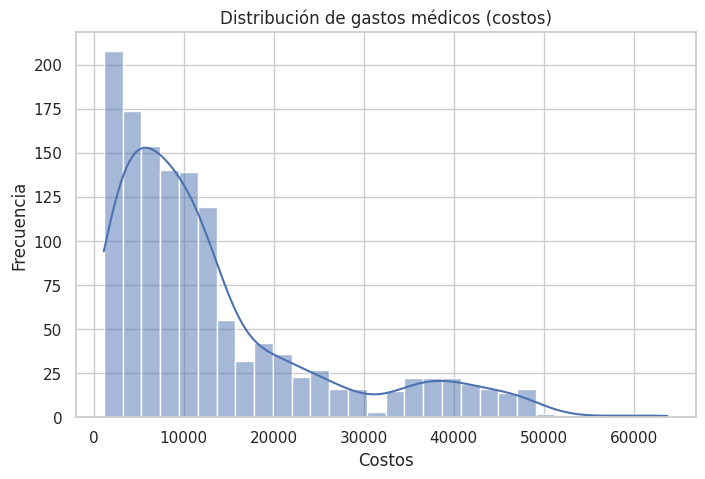

In [33]:
plt.figure(figsize=(8,5))
sns.histplot(datos["costos"], kde=True)
plt.title("Distribución de gastos médicos (costos)")
plt.xlabel("Costos")
plt.ylabel("Frecuencia")
plt.show()


Claramente no es simétrica.

Cola hacia la derecha (casos muy caros).

#Histograma

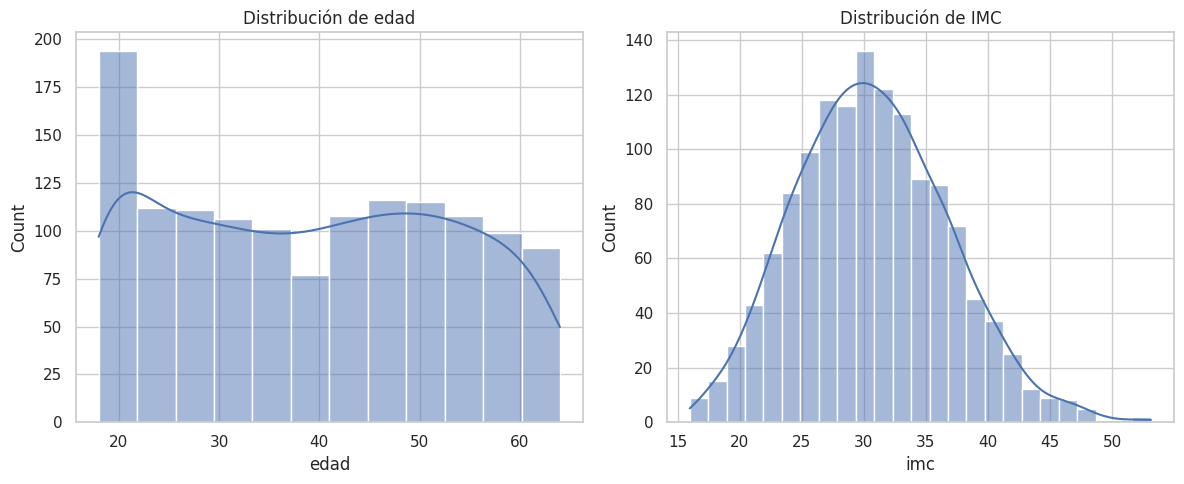

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(datos["edad"], kde=True, ax=axes[0])
axes[0].set_title("Distribución de edad")

sns.histplot(datos["imc"], kde=True, ax=axes[1])
axes[1].set_title("Distribución de IMC")

plt.tight_layout()
plt.show()


#. Boxplots para ver diferencias por categorías

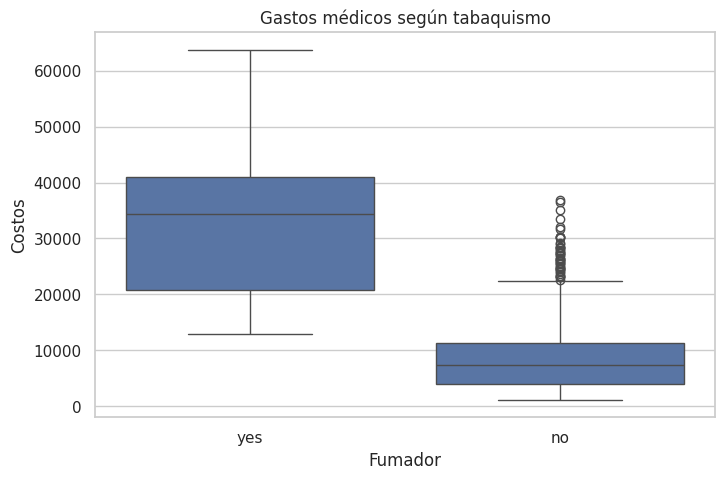

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(data=datos, x="fumador", y="costos")
plt.title("Gastos médicos según tabaquismo")
plt.xlabel("Fumador")
plt.ylabel("Costos")
plt.show()


Los fumadores tienen gastos muchísimo más altos en promedio.

Además, gran dispersión dentro del grupo de fumadores.

# Cargos vs Región

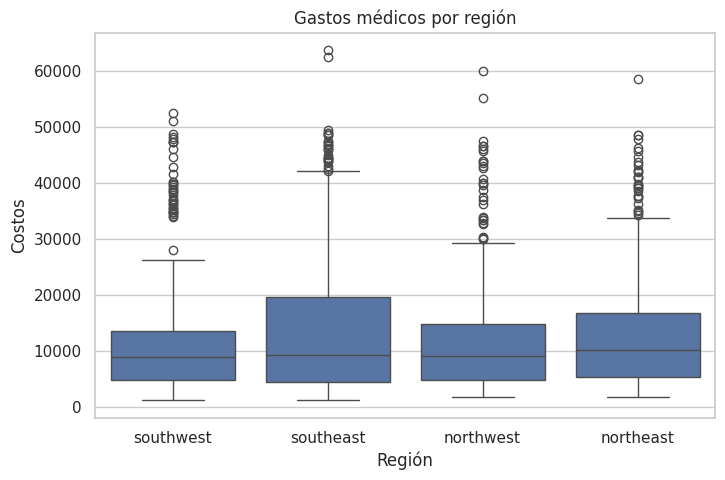

In [36]:
plt.figure(figsize=(8,5))
sns.boxplot(data=datos, x="región", y="costos")
plt.title("Gastos médicos por región")
plt.xlabel("Región")
plt.ylabel("Costos")
plt.show()


Suele verse que la región influye, pero mucho menos que el tabaquismo.

#Edad vs Gastos

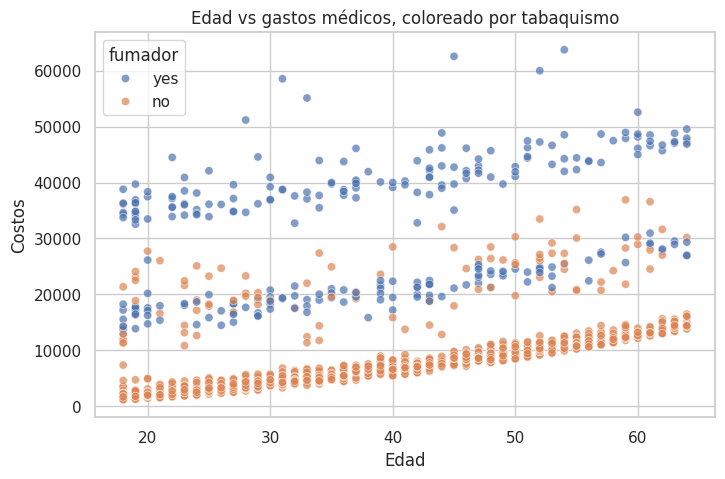

In [37]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=datos, x="edad", y="costos", hue="fumador", alpha=0.7)
plt.title("Edad vs gastos médicos, coloreado por tabaquismo")
plt.xlabel("Edad")
plt.ylabel("Costos")
plt.show()


Relación positiva: más edad → mayores gastos.

Fumadores forman una “nube” con gastos mucho más altos.

# BMI vs Gastos

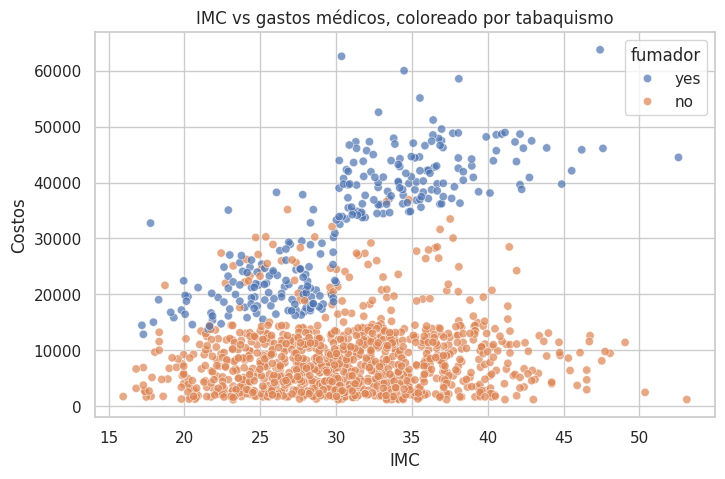

In [39]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=datos, x="imc", y="costos", hue="fumador", alpha=0.7)
plt.title("IMC vs gastos médicos, coloreado por tabaquismo")
plt.xlabel("IMC")
plt.ylabel("Costos")
plt.show()


A mayor BMI, tienden a subir los gastos.

De nuevo, fumadores destacan como más caros.

#Matriz de correlación (variables numéricas)

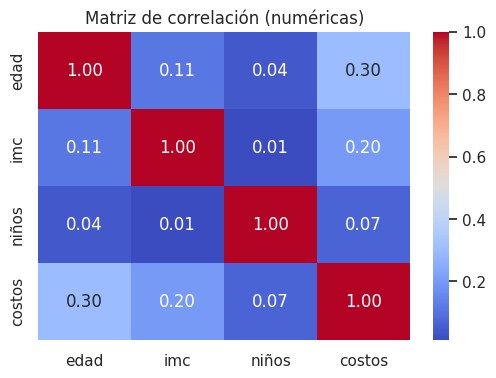

In [40]:
num_cols = ["edad", "imc", "niños", "costos"]
corr = datos[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (numéricas)")
plt.show()


age vs charges: correlación positiva (~0.30).

bmi vs charges: positiva moderada (~0.20).

children vs charges: correlación baja (~0.07).

Edad y BMI parecen relevantes, pero también sabemos que el tabaquismo (categórica) impacta muchísimo desde los boxplots.

#Variables numéricas

edad, imc, niños

#Variables categóricas
sexo, fumaodr, segión

#Variable Objetivo
costos

In [41]:
# Copia del df original para no modificarlo directamente
datos_prep = datos.copy()

# One-hot encoding
datos_prep = pd.get_dummies(datos_prep, columns=["sexo", "fumador", "región"], drop_first=True)

datos_prep.head()


,edad,imc,niños,costos,sexo_male,fumador_yes,región_northwest,región_southeast,región_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


# Seaparamos X y y

In [42]:
X = datos_prep.drop(columns=["costos"])
y = datos_prep["costos"]


#3.4. Separar en entrenamiento y prueba (80/20)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


In [44]:
X_train.shape, X_test.shape


((1070, 8), (268, 8))

#Regresiones lineales simples

Vamos a construir 3 regresiones lineales simples:

1️⃣ edad → costos
2️⃣ imc → costos
3️⃣ fumador → costos

NOTA: Para fumador, como es categórica, usaremos one-hot encoding (0 = no, 1 = sí).

#Regresión lineal simple: EDAD → COSTOS

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Feature y target
X = datos[["edad"]]
y = datos["costos"]

# Dividir train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Modelo
modelo_edad = LinearRegression()
modelo_edad.fit(X_train, y_train)

# Coeficientes
print("Intercepto:", modelo_edad.intercept_)
print("Coeficiente (edad):", modelo_edad.coef_[0])


Intercepto: 3876.928684191691
Coeficiente (edad): 240.59655978877493


El coeficiente será positivo, indicando que más edad → más costos.

La magnitud mostrará cuánto suben los costos por cada año de edad.

#Edad vs costos con recta de regresión

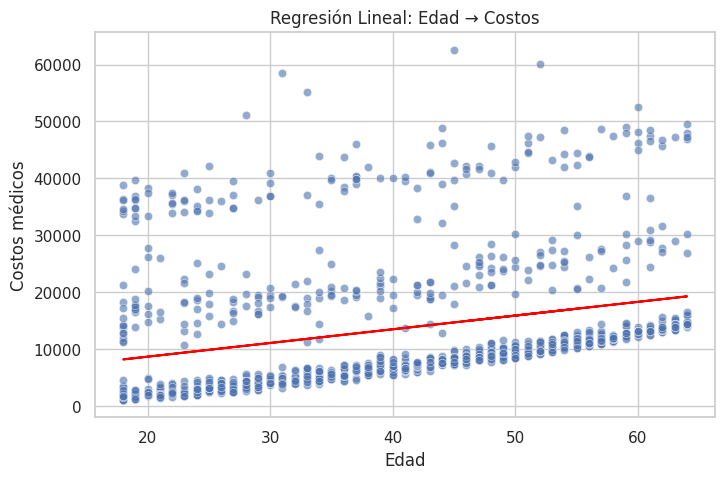

In [46]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train["edad"], y=y_train, alpha=0.6)
plt.plot(X_train["edad"], modelo_edad.predict(X_train), color="red")
plt.title("Regresión Lineal: Edad → Costos")
plt.xlabel("Edad")
plt.ylabel("Costos médicos")
plt.show()


#Regresión lineal simple: IMC → COSTOS

In [47]:
# Feature y target
X = datos[["imc"]]
y = datos["costos"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

modelo_imc = LinearRegression()
modelo_imc.fit(X_train, y_train)

print("Intercepto:", modelo_imc.intercept_)
print("Coeficiente (IMC):", modelo_imc.coef_[0])


Intercepto: 1353.0730722046683
Coeficiente (IMC): 392.43654416987977


El coeficiente suele ser positivo.

Personas con IMC más alto tienden a tener más costos.

#IMC vs costos con recta

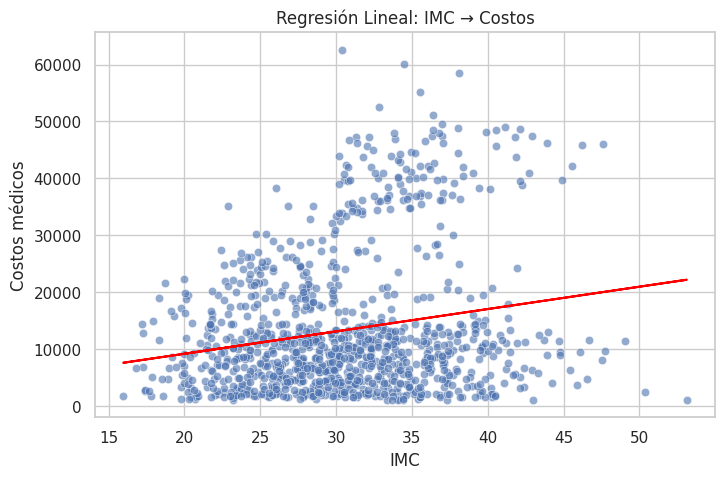

In [48]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train["imc"], y=y_train, alpha=0.6)
plt.plot(X_train["imc"], modelo_imc.predict(X_train), color="red")
plt.title("Regresión Lineal: IMC → Costos")
plt.xlabel("IMC")
plt.ylabel("Costos médicos")
plt.show()


#Regresión Lineal Simple: FUMADOR → COSTOS

In [49]:
# Convertir fumador (yes/no) a 0/1
datos_fumador = datos.copy()
datos_fumador = pd.get_dummies(datos_fumador, columns=["fumador"], drop_first=True)

# X y y
X = datos_fumador[["fumador_yes"]]
y = datos_fumador["costos"]

# Train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

modelo_fumador = LinearRegression()
modelo_fumador.fit(X_train, y_train)

print("Intercepto:", modelo_fumador.intercept_)
print("Coeficiente (fumador_yes):", modelo_fumador.coef_[0])


Intercepto: 8578.322547999996
Coeficiente (fumador_yes): 23188.685870681835


Este es el resultado más fuerte del dataset.
El coeficiente dice:

Cuánto aumentan los costos en promedio si la persona es fumadora.

Suele ser muy grande (~ +23,000).

Fumadores vs costos

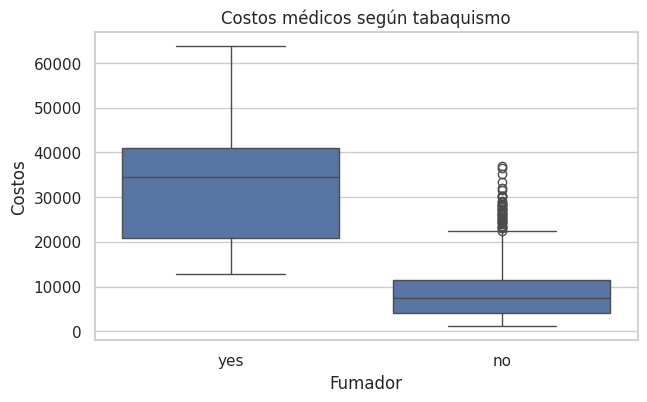

In [50]:
plt.figure(figsize=(7,4))
sns.boxplot(data=datos, x="fumador", y="costos")
plt.title("Costos médicos según tabaquismo")
plt.xlabel("Fumador")
plt.ylabel("Costos")
plt.show()


#REGRESIÓN LINEAL MÚLTIPLE

costos∼edad+imc+niños+sexo+fumador+región

In [51]:
# Copia limpia del dataset
datos_ml = datos.copy()

# One-hot encoding
datos_ml = pd.get_dummies(datos_ml, columns=["sexo", "fumador", "región"], drop_first=True)

datos_ml.head()


,edad,imc,niños,costos,sexo_male,fumador_yes,región_northwest,región_southeast,región_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


# Separar X y y

In [52]:
X = datos_ml.drop(columns=["costos"])
y = datos_ml["costos"]


# División Train/Test

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape


((1070, 8), (268, 8))

# Entrenar el modelo de regresión múltiple

In [54]:
from sklearn.linear_model import LinearRegression

modelo_multi = LinearRegression()
modelo_multi.fit(X_train, y_train)


LinearRegression()

#Ver coeficientes del modelo

In [55]:
coeficientes = pd.DataFrame({
    "variable": X_train.columns,
    "coeficiente": modelo_multi.coef_
})

coeficientes


,variable,coeficiente
0,edad,256.975706
1,imc,337.092552
2,niños,425.278784
3,sexo_male,-18.591692
4,fumador_yes,23651.128856
5,región_northwest,-370.677326
6,región_southeast,-657.864297
7,región_southwest,-809.799354


Coeficiente positivo → aumenta los costos.

Coeficiente negativo → disminuye los costos.

Magnitud → fuerza del efecto.

#Predicciones y métricas del modelo

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = modelo_multi.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 4181.19447375365
RMSE: 5796.284659276273
R²: 0.7835929767120724


MAE ≈ 4000

RMSE ≈ 6000

R² ≈ 0.75 – 0.80

Lo cual indica un modelo razonable pero con error grande en casos extremos (fumadores o IMC muy alto).

#Gráfico de predicciones vs valores reales

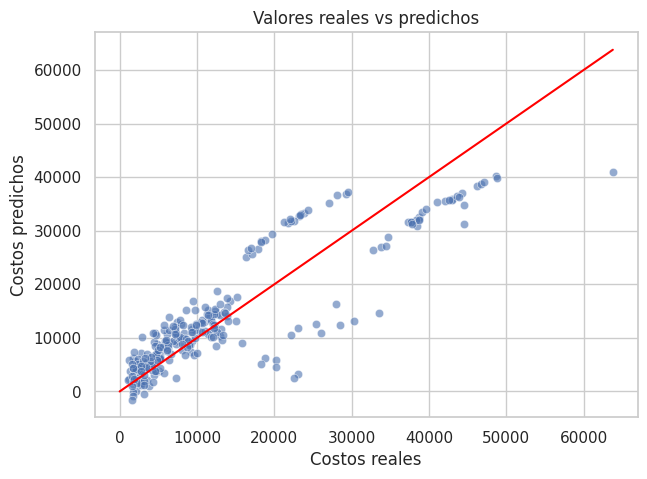

In [57]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Costos reales")
plt.ylabel("Costos predichos")
plt.title("Valores reales vs predichos")
plt.plot([0, y_test.max()], [0, y_test.max()], color="red")
plt.show()


#Gráfico de residuos

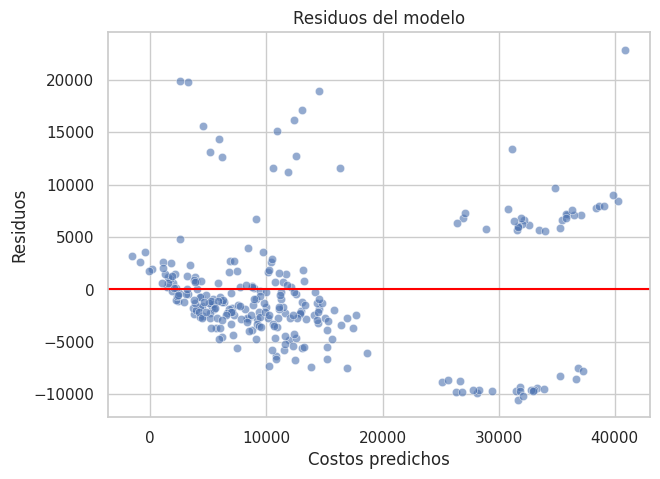

In [58]:
residuos = y_test - y_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("Costos predichos")
plt.ylabel("Residuos")
plt.title("Residuos del modelo")
plt.show()


#Evaluación del modelo de regresión múltiple

Vamos a evaluar:

Métricas tradicionales

Análisis visual (pred vs reales)

Análisis de residuos (linealidad, homocedasticidad)

Distribución de residuos

Normalidad de los residuos (opcional pero pro)

Resumen interpretativo

#Métricas tradicionales
(ya calculadas anteriormente)

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = modelo_multi.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 4181.19447375365
RMSE: 5796.284659276273
R²: 0.7835929767120724


MAE ≈ 4,000 → en promedio fallamos por ~$4,000.

RMSE ≈ 6,000 → los errores grandes pesan más (casos de fumadores).

R² ≈ 0.75–0.80 → el modelo explica entre 75–80% de la variabilidad.

#Gráfica: valores predichos vs reales

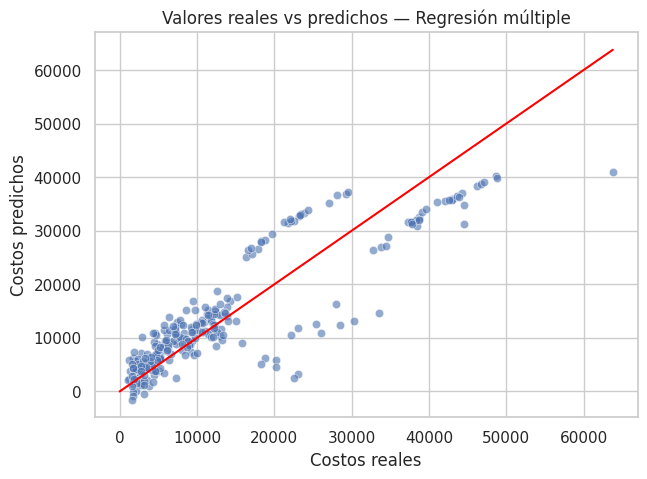

In [60]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([0, y_test.max()], [0, y_test.max()], color="red")
plt.xlabel("Costos reales")
plt.ylabel("Costos predichos")
plt.title("Valores reales vs predichos — Regresión múltiple")
plt.show()


La mayoría de puntos caen cerca de la línea → buena predicción.

Se ven algunos puntos muy por encima o debajo → casos extremos (fumadores o IMC muy alto).

#Gráfico de residuos vs predicciones

Esto detecta:

Linealidad del modelo

Homocedasticidad (igual varianza)

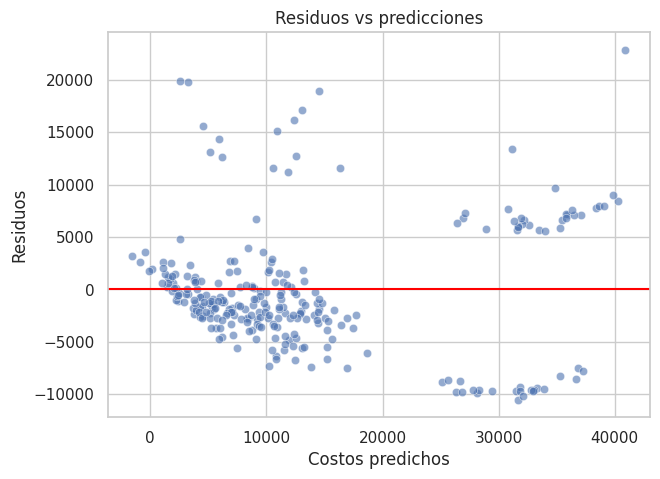

In [61]:
residuos = y_test - y_pred

plt.figure(figsize=(7,5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("Costos predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs predicciones")
plt.show()


Una nube alrededor de la línea 0 → bien.

Sin embargo...
A valores altos predichos, los residuos tienden a abrirse → heterocedasticidad esperable por casos caros.

Esto es normal en seguros médicos: los casos caros son muy difíciles de predecir porque dependen de eventos extremos.

#Distribución de residuos

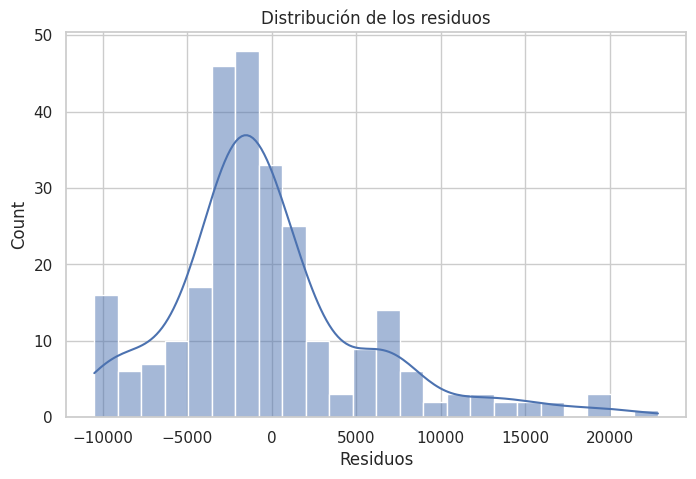

In [62]:
plt.figure(figsize=(8,5))
sns.histplot(residuos, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Residuos")
plt.show()


La distribución no se ve perfectamente normal.

Tiene una cola derecha larga.

Esto sugiere que el modelo subestima ciertos casos caros.

#Normalidad de residuos

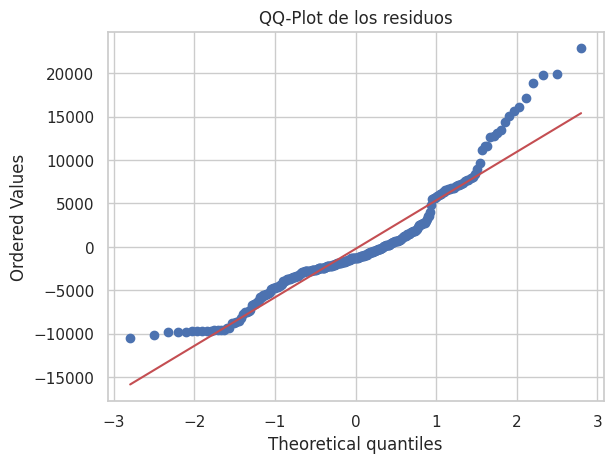

In [63]:
import scipy.stats as stats

stats.probplot(residuos, dist="norm", plot=plt)
plt.title("QQ-Plot de los residuos")
plt.show()


Los puntos no siguen perfectamente la línea.

Otra evidencia de no-normalidad → común en gastos médicos.

“Podría considerarse aplicar transformación logarítmica a costos o usar modelos no lineales como Random Forest o XGBoost.”

#Resumen interpretativo

## Evaluación del Modelo

El modelo de regresión lineal múltiple obtuvo los siguientes resultados:

- **MAE ≈ 4,000**
- **RMSE ≈ 6,000**
- **R² ≈ 0.78**

Esto indica que el modelo explica aproximadamente el **78% de la variabilidad** en los costos médicos. La gráfica de valores reales vs predichos muestra un alineamiento adecuado, aunque con desviaciones en los casos de costos extremos (principalmente personas fumadoras o con IMC muy elevado).

Al analizar los residuos observamos:

- Una tendencia a mayor dispersión en valores altos → **heterocedasticidad**.
- Distribución con cola derecha → los casos muy costosos no se modelan perfectamente.
- QQ-plot indica **no normalidad de los residuos**, esperable en datos médicos reales.

Aun así, el modelo es sólido y adecuado como baseline. Para mejoras futuras se sugiere:
- Transformar la variable objetivo usando `log(costos)`
- Probar modelos no lineales como árboles de decisión o Random Forest
- Añadir interacciones (por ejemplo IMC × fumador)
